# Inadimpletes - Hackday 3° Edição

In [1]:
# !pip install sweetviz xgboost category_encoders

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz
import pickle

from sklearn.metrics       import mean_absolute_error, mean_squared_error, f1_score
from sklearn.ensemble      import RandomForestClassifier
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
import sklearn.model_selection as ms
from category_encoders       import TargetEncoder
from xgboost import XGBClassifier

%matplotlib inline
sns.set_theme()
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 500)
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 16

# Data Collection

In [4]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,21,278.17,2577.05,24196.90,104.31,31.04,6,5,7,21,14,9,15,Não,Não,Negar
1,11920,40,268.87,2465.39,19227.38,69.86,36.92,5,8,5,40,23,10,18,Não,Não,Negar
2,8910,36,446.64,1055.29,42822.28,134.20,34.56,0,3,6,26,13,3,15,Sim,Não,Negar
3,4964,58,321.14,703.05,51786.83,297.35,31.49,0,3,7,12,7,2,1,Sim,Não,Negar
4,10100,35,428.72,891.29,44626.85,134.20,28.03,2,8,7,24,10,8,20,Sim,Não,Negar


## Data dimension

In [5]:
df_train.shape

(9500, 17)

## Class distribution

In [6]:
df_train['limite_adicional'].value_counts(normalize=True)*100

Negar      84.16
Conceder   15.84
Name: limite_adicional, dtype: float64

## Data types

In [7]:
df_train.dtypes

id_cliente                   int64
idade                        int64
saldo_atual                float64
divida_atual               float64
renda_anual                float64
valor_em_investimentos     float64
taxa_utilizacao_credito    float64
num_emprestimos              int64
num_contas_bancarias         int64
num_cartoes_credito          int64
dias_atraso_dt_venc          int64
num_pgtos_atrasados          int64
num_consultas_credito        int64
taxa_juros                   int64
investe_exterior            object
pessoa_polit_exp            object
limite_adicional            object
dtype: object

## NAN?

In [8]:
df_train.isna().sum()

id_cliente                 0
idade                      0
saldo_atual                0
divida_atual               0
renda_anual                0
valor_em_investimentos     0
taxa_utilizacao_credito    0
num_emprestimos            0
num_contas_bancarias       0
num_cartoes_credito        0
dias_atraso_dt_venc        0
num_pgtos_atrasados        0
num_consultas_credito      0
taxa_juros                 0
investe_exterior           0
pessoa_polit_exp           0
limite_adicional           0
dtype: int64

## Descriptive Statistics

In [9]:
df_train.describe(include='object').T.sort_values(by='unique', ascending=False)

,count,unique,top,freq
investe_exterior,9500,2,Não,7177
pessoa_polit_exp,9500,2,Não,8917
limite_adicional,9500,2,Negar,7995


In [10]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id_cliente,9500.00,6210.53,3603.24,1.00,3091.75,6172.50,9320.25,12500.00
idade,9500.00,126.40,685.04,18.00,28.00,38.00,47.00,8598.00
saldo_atual,9500.00,404.53,217.70,0.09,272.36,337.17,471.26,1602.04
divida_atual,9500.00,1437.09,1156.26,0.23,573.62,1175.73,1963.33,4998.07
renda_anual,9500.00,195037.27,1454273.73,10473.87,26207.90,45991.11,80449.83,23279657.98
valor_em_investimentos,9500.00,612.00,2002.44,0.00,76.08,134.20,249.18,10000.00
taxa_utilizacao_credito,9500.00,32.27,5.11,20.99,28.08,32.26,36.46,49.56
num_emprestimos,9500.00,10.86,62.56,0.00,2.00,3.00,6.00,1496.00
num_contas_bancarias,9500.00,17.55,120.98,0.00,3.00,6.00,7.00,1779.00
num_cartoes_credito,9500.00,21.43,122.68,1.00,4.00,6.00,7.00,1479.00


## Data Cleaning

In [11]:
df2 = df_train.copy()

In [10]:
def filter_outliers(df, col, factor=2):
    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)

    iqr = q3 - q1
    max_bouderie = q3 + iqr * factor
    min_bouderie = q1 - iqr * factor

    return df.loc[(df[col] >= min_bouderie) & (df[col] <= max_bouderie), :]

In [11]:
df2 = filter_outliers(df2, 'idade')
df2 = filter_outliers(df2, 'valor_em_investimentos')
df2 = filter_outliers(df2, 'taxa_juros')
df2 = filter_outliers(df2, 'renda_anual')
df2 = filter_outliers(df2, 'num_emprestimos')
df2 = filter_outliers(df2, 'num_cartoes_credito')
df2 = filter_outliers(df2, 'num_contas_bancarias')
df2 = filter_outliers(df2, 'num_consultas_credito')

## Exploratory Data Analysis

In [12]:
df3 = df2.copy()

### Univariate Analysis

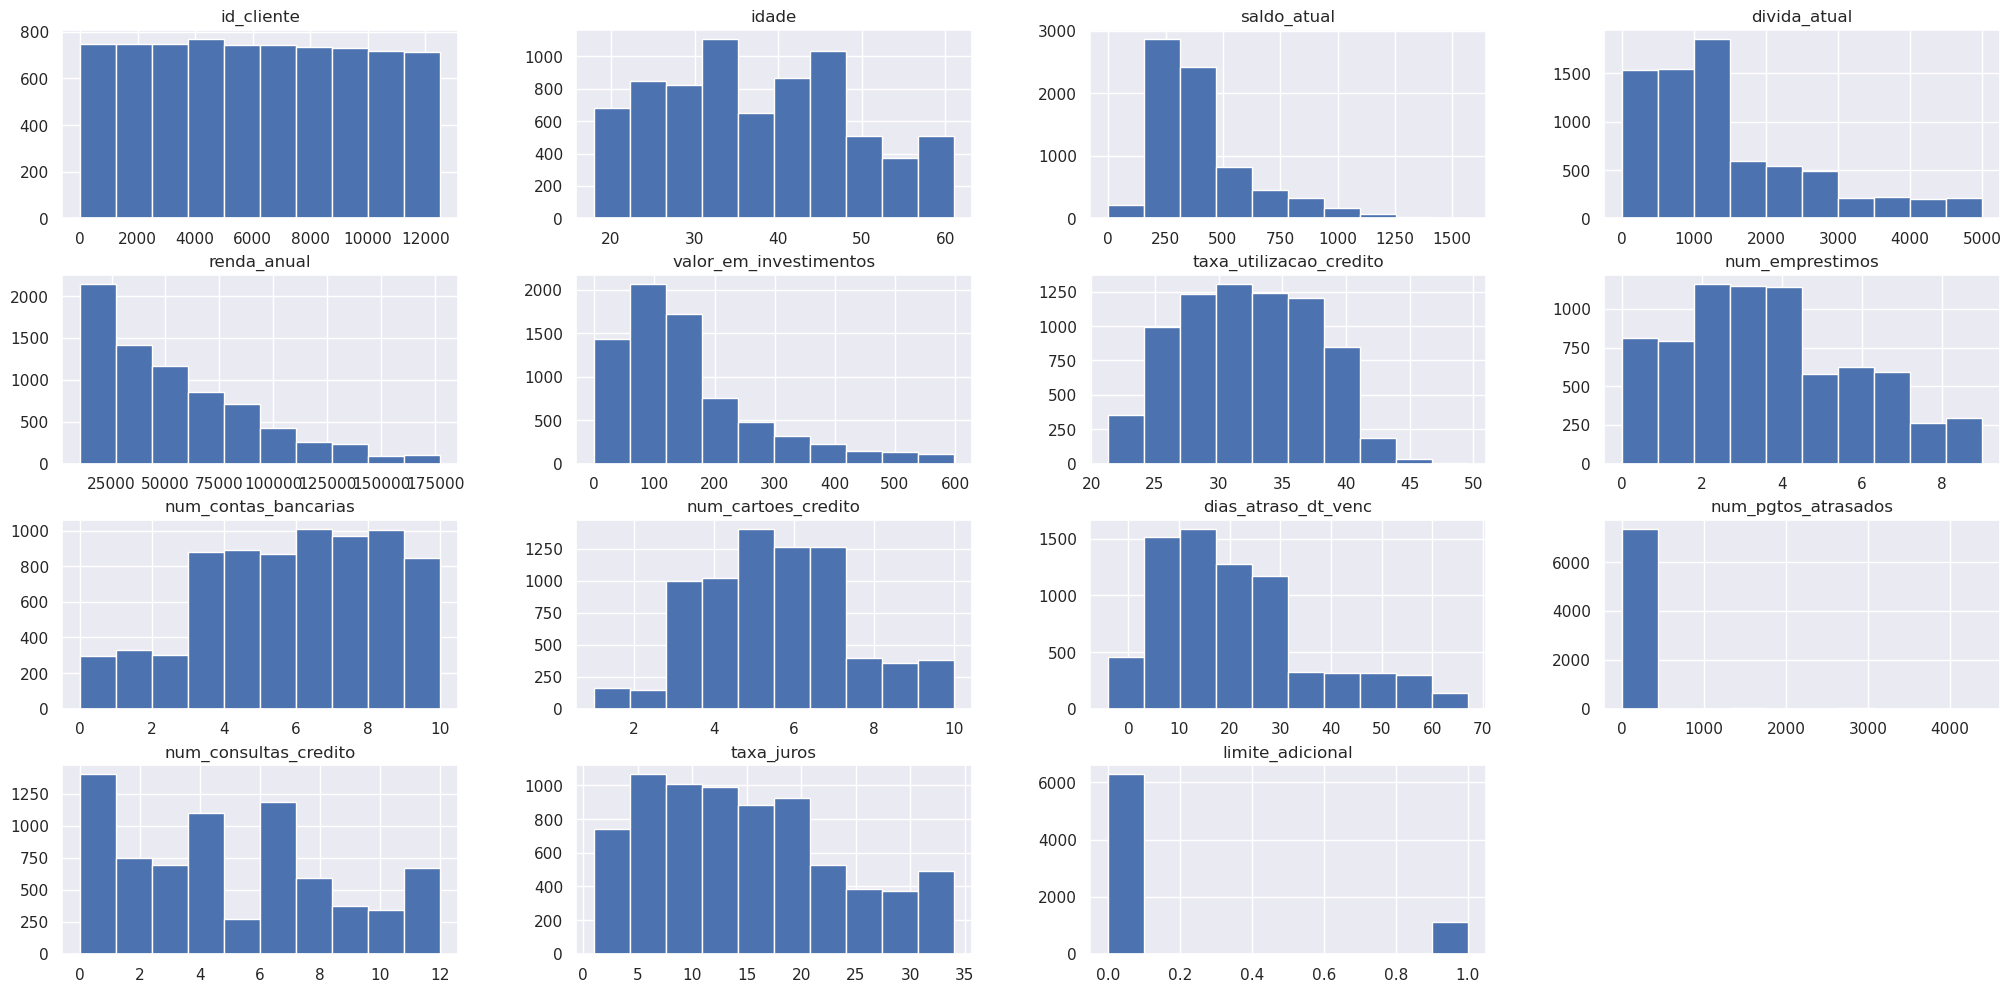

In [13]:
d_class = {
    'Negar': 0,
    'Conceder': 1
}

df3['limite_adicional'] = df3['limite_adicional'].map(d_class)
num_attr = df3.select_dtypes(include=['int64', 'float64'])

num_attr.hist();

### Bivariate Analysis

### Multivariate Analysis

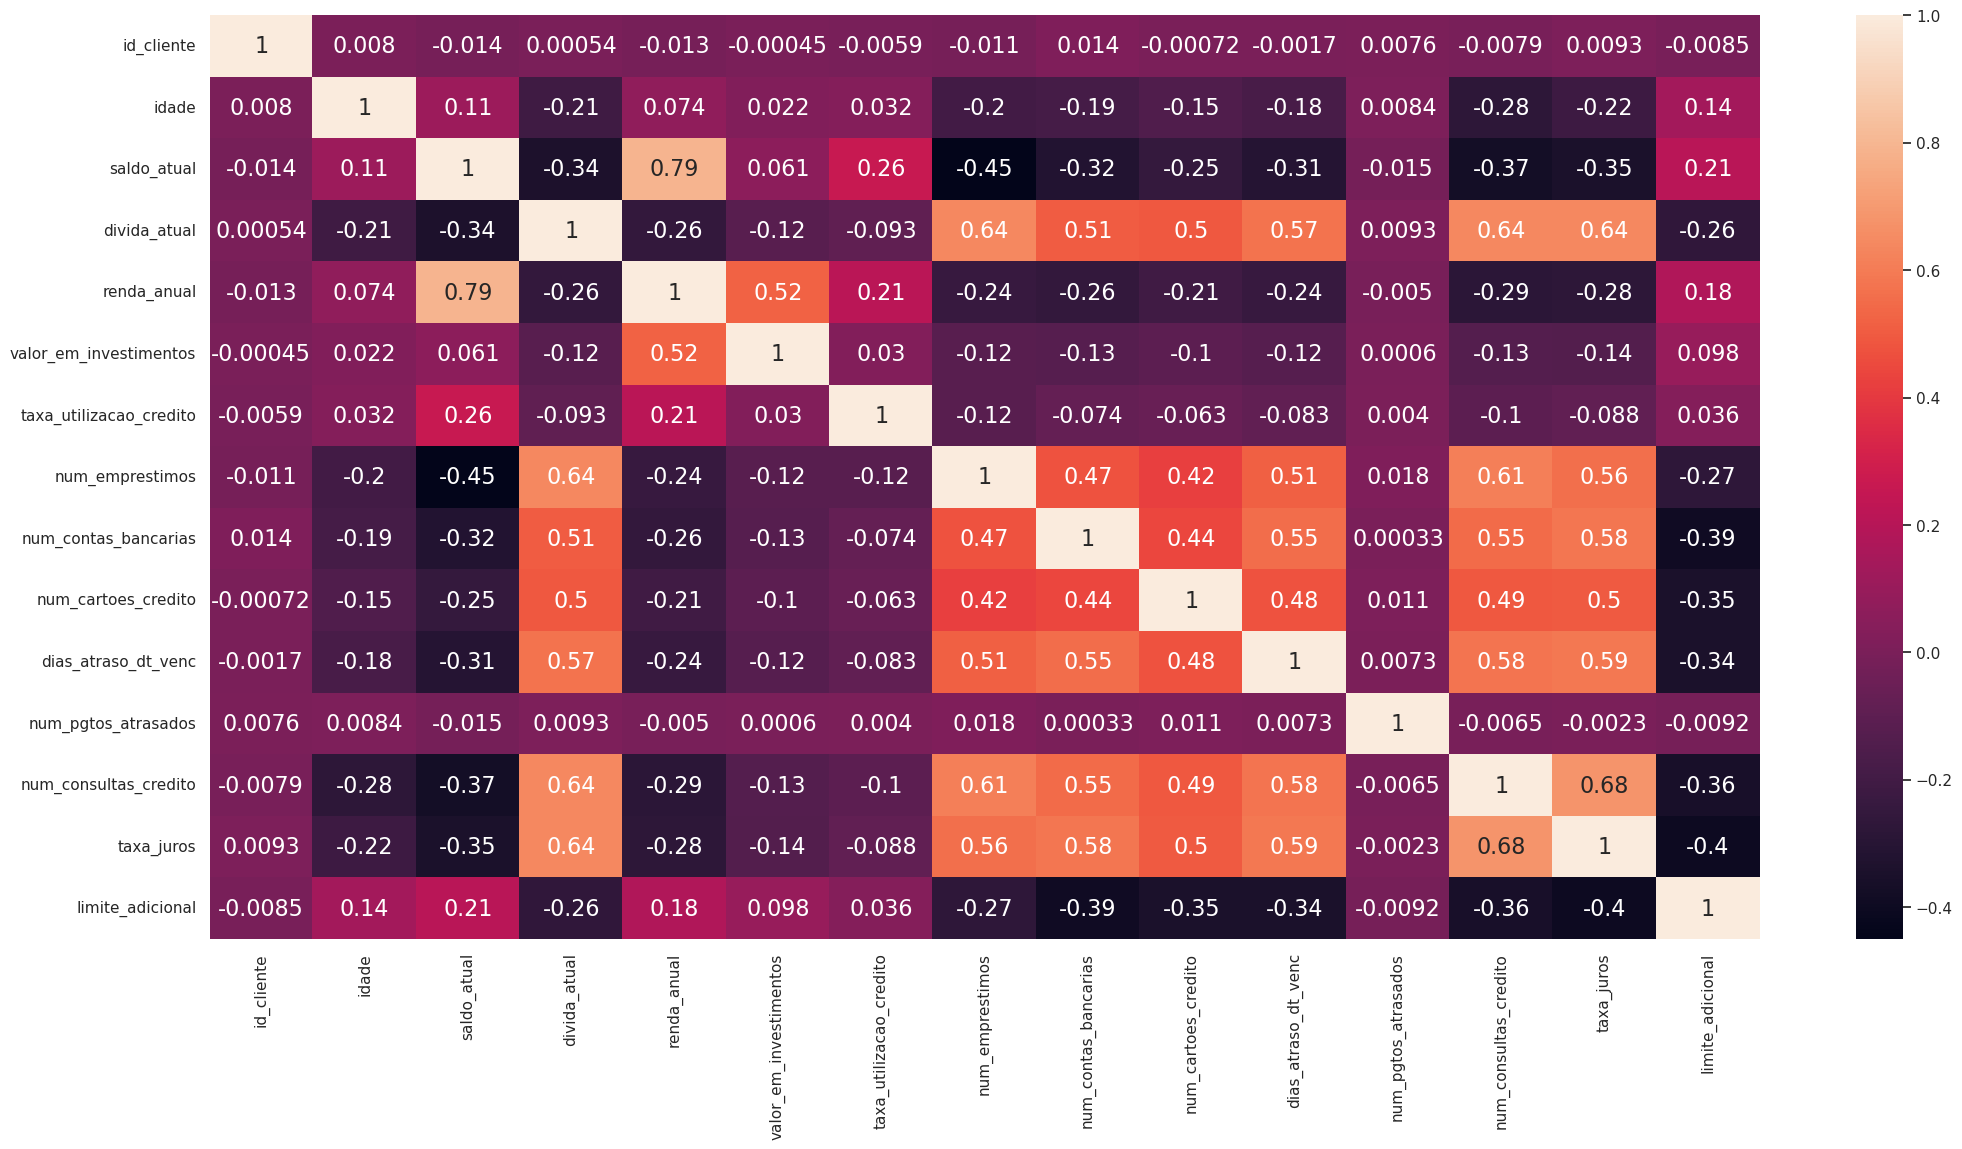

In [14]:
correlation = num_attr.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

## Data Preparation

In [15]:
df_pp = df2.copy()

## Remove useless features

In [16]:
cols_remove = ['id_cliente', 'num_pgto_atrasado']
df_pp = df_pp.drop(columns=cols_remove)

In [17]:
X = df_pp.drop(columns=['limite_adicional'])
y = df_pp['limite_adicional']

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Encoding

### Class Encoding

In [18]:
#class_col_enc = 'bank_account'

d_class = {
    'Negar': 0,
    'Conceder': 1
}

y_train = y_train.map(d_class)

### Frequency encoding

In [19]:
X_train['investe_exterior'] = X_train['investe_exterior'].map(lambda x: 0.76 if x == 0.15 else 0.24)
X_train['pessoa_polit_exp'] = X_train['pessoa_polit_exp'].map(lambda x: 0.94 if x == 0.16 else 0.06)


### Normalization

In [20]:
ss = StandardScaler()

# saldo_autal
X_train['taxa_utilizacao_credito'] = ss.fit_transform( X_train[['taxa_utilizacao_credito']].values )

### Rescaling

In [21]:
rs = RobustScaler()
mms = MinMaxScaler()

## Robust Scaler
# idade
X_train['idade'] = rs.fit_transform( X_train[['idade']].values )
pickle.dump( rs, open( 'parameter/idade_scaler.pkl', 'wb') )

# saldo_atual
X_train['saldo_atual'] = rs.fit_transform( X_train[['saldo_atual']].values )
pickle.dump( rs, open( 'parameter/saldo_atual_scaler.pkl', 'wb') )

# renda_anual
X_train['renda_anual'] = rs.fit_transform( X_train[['renda_anual']].values )
pickle.dump( rs, open( 'parameter/renda_anual_scaler.pkl', 'wb') )

# valor_em_investimentos
X_train['valor_em_investimentos'] = rs.fit_transform( X_train[['valor_em_investimentos']].values )
pickle.dump( rs, open( 'parameter/valor_em_investimentos_scaler.pkl', 'wb') )

# num_emprestimos
X_train['num_emprestimos'] = rs.fit_transform( X_train[['num_emprestimos']].values )
pickle.dump( rs, open( 'parameter/num_emprestimos_scaler.pkl', 'wb') )

# num_contas_bancarias
X_train['num_contas_bancarias'] = rs.fit_transform( X_train[['num_contas_bancarias']].values )
pickle.dump( rs, open( 'parameter/num_contas_bancarias_scaler.pkl', 'wb') )

# num_cartoes_credito
X_train['num_cartoes_credito'] = rs.fit_transform( X_train[['num_cartoes_credito']].values )
pickle.dump( rs, open( 'parameter/num_cartoes_credito_scaler.pkl', 'wb') )

# num_pgtos_atrasados
X_train['num_pgtos_atrasados'] = rs.fit_transform( X_train[['num_pgtos_atrasados']].values )
pickle.dump( rs, open( 'parameter/num_pgtos_atrasados_scaler.pkl', 'wb') )

# num_consultas_credito
X_train['num_consultas_credito'] = rs.fit_transform( X_train[['num_consultas_credito']].values )
pickle.dump( rs, open( 'parameter/num_consultas_credito_scaler.pkl', 'wb') )

# taxa_juros
X_train['taxa_juros'] = rs.fit_transform( X_train[['taxa_juros']].values )
pickle.dump( rs, open( 'parameter/taxa_juros_scaler.pkl', 'wb') )

## MinMax Scaler
# dias_atraso_dt_venc
X_train['dias_atraso_dt_venc'] = mms.fit_transform( X_train[['dias_atraso_dt_venc']].values )
pickle.dump( rs, open( 'parameter/dias_atraso_dt_venc_scaler.pkl', 'wb') )

# divida_atual
X_train['divida_atual'] = mms.fit_transform( X_train[['divida_atual']].values )
pickle.dump( rs, open( 'parameter/divida_atual_scaler.pkl', 'wb') )

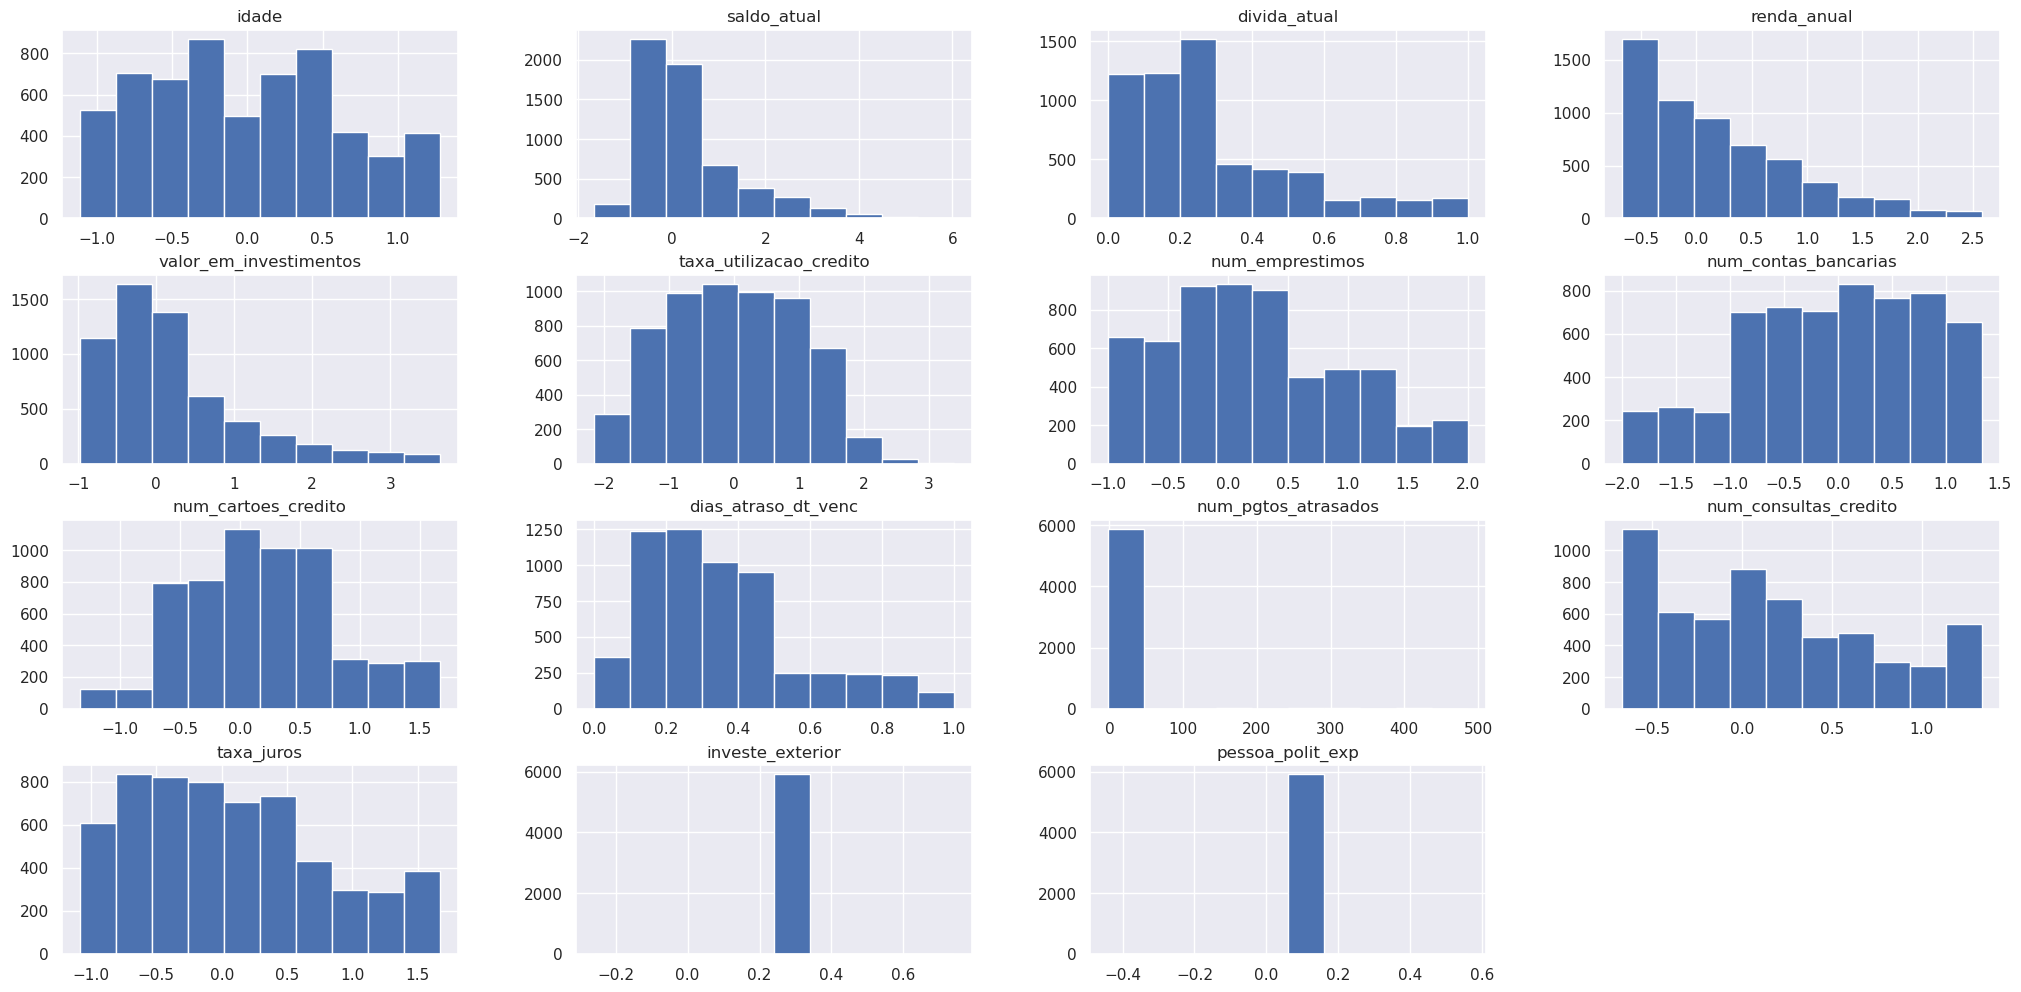

In [23]:
num_attr2 = X_train.select_dtypes(include=['int64', 'float64'])

num_attr2.hist();

In [25]:
X_train.shape

(5916, 15)

## Modeling & Evaluation

In [21]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier

In [22]:
rf = RandomForestClassifier(criterion='entropy',\
                            min_samples_leaf=10, n_estimators=100,\
                            max_features=None, random_state=42)
cross_val_score(estimator=rf, X=X_train,y=y_train,scoring='f1_weighted',cv=5, n_jobs=-1)

array([0.88961935, 0.86247126, 0.8671679 , 0.87668846, 0.88305022])

In [23]:
rf = RandomForestClassifier(criterion='entropy',\
                            min_samples_leaf=10, n_estimators=100,\
                            max_features=None, random_state=42)
cross_validate(estimator=rf, X=X_train,y=y_train,scoring='f1_weighted',cv=5, n_jobs=-1, return_train_score=True)

{'fit_time': array([1.70603466, 1.68082857, 1.65204048, 1.67383194, 1.67788625]),
 'score_time': array([0.02658415, 0.02614236, 0.02622104, 0.02640867, 0.02637434]),
 'test_score': array([0.88961935, 0.86247126, 0.8671679 , 0.87668846, 0.88305022]),
 'train_score': array([0.94580366, 0.94368169, 0.93855101, 0.94117306, 0.9415645 ])}

In [24]:
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_leaf=10, random_state=42)

In [25]:
X_test

,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp
3545,27,1302.12,233.93,161726.16,87.79,41.37,2,5,3,0,5,3,2,Sim,Não
3652,35,217.85,1442.31,43429.12,346.71,30.05,2,7,6,25,17,7,12,Não,Não
8615,31,29.96,2860.18,83103.05,571.77,30.07,8,7,6,29,15,10,33,Não,Não
4202,39,360.06,2083.28,82159.68,166.35,25.98,7,6,8,53,15,7,30,Não,Não
627,36,348.12,1464.74,46857.12,104.55,29.09,3,1,7,15,1,3,8,Não,Não
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8745,39,372.47,2574.10,60182.90,151.11,38.10,6,8,3,11,12,7,29,Não,Não
143,33,592.77,2487.17,77565.47,145.23,28.78,2,6,10,27,18,7,27,Sim,Não
64,36,187.52,1334.81,39315.72,330.10,35.83,2,8,10,48,17,7,28,Não,Não
1424,28,302.20,3680.76,27680.50,62.85,34.98,9,10,7,29,25,9,26,Não,Não


In [26]:
X_train

,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp
8206,0.39,0.20,0.15,-0.23,-0.69,0.04,-0.67,-0.67,0.67,0.37,-0.78,0.17,0.50,0.24,0.06
5009,0.61,-0.98,0.40,-0.05,0.97,0.34,1.67,0.00,0.67,0.55,0.67,1.17,0.83,0.24,0.06
9241,-1.06,-0.06,0.27,-0.37,0.06,1.40,0.33,0.67,0.67,0.85,-0.22,1.33,0.83,0.24,0.06
2969,0.61,-0.90,0.02,-0.08,1.17,-0.14,0.33,0.00,0.33,0.41,0.11,-0.67,-0.67,0.24,0.06
8606,-0.83,-0.26,0.32,-0.61,-0.62,0.69,1.33,0.67,0.33,0.39,-0.33,0.50,0.67,0.24,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,0.00,1.03,0.96,0.92,0.07,-1.02,1.00,0.67,0.00,0.30,1.00,0.83,0.42,0.24,0.06
6740,0.06,-0.42,0.74,-0.64,-0.52,-1.68,1.33,0.67,1.67,0.56,0.11,1.17,0.25,0.24,0.06
6945,0.67,0.06,0.72,0.40,-0.30,0.27,1.33,0.00,1.67,0.38,0.67,0.83,1.33,0.24,0.06
1105,-0.56,2.94,0.29,1.56,0.68,0.63,-0.67,-0.33,-1.33,0.24,-1.11,-0.17,-0.75,0.24,0.06


In [27]:
y_test = y_test.map(d_class)

In [28]:
X_test['investe_exterior'] = X_test['investe_exterior'].map(lambda x: 0.76 if x == 0.15 else 0.24)
X_test['pessoa_polit_exp'] = X_test['pessoa_polit_exp'].map(lambda x: 0.94 if x == 0.16 else 0.06)

X_test['taxa_utilizacao_credito'] = ss.fit_transform( X_test[['taxa_utilizacao_credito']].values )

rs = RobustScaler()
mms = MinMaxScaler()

## Robust Scaler
# idade
X_test['idade'] = rs.fit_transform( X_test[['idade']].values )

# saldo_atual
X_test['saldo_atual'] = rs.fit_transform( X_test[['saldo_atual']].values )

# renda_anual
X_test['renda_anual'] = rs.fit_transform( X_test[['renda_anual']].values )

# valor_em_investimentos
X_test['valor_em_investimentos'] = rs.fit_transform( X_test[['valor_em_investimentos']].values )

# num_emprestimos
X_test['num_emprestimos'] = rs.fit_transform( X_test[['num_emprestimos']].values )

# num_contas_bancarias
X_test['num_contas_bancarias'] = rs.fit_transform( X_test[['num_contas_bancarias']].values )

# num_cartoes_credito
X_test['num_cartoes_credito'] = rs.fit_transform( X_test[['num_cartoes_credito']].values )

# num_pgtos_atrasados
X_test['num_pgtos_atrasados'] = rs.fit_transform( X_test[['num_pgtos_atrasados']].values )

# num_consultas_credito
X_test['num_consultas_credito'] = rs.fit_transform( X_test[['num_consultas_credito']].values )

# taxa_juros
X_test['taxa_juros'] = rs.fit_transform( X_test[['taxa_juros']].values )

## MinMax Scaler
# dias_atraso_dt_venc
X_test['dias_atraso_dt_venc'] = mms.fit_transform( X_test[['dias_atraso_dt_venc']].values )

# divida_atual
X_test['divida_atual'] = mms.fit_transform( X_test[['divida_atual']].values )

/tmp/ipykernel_11830/4214568727.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['investe_exterior'] = X_test['investe_exterior'].map(lambda x: 0.76 if x == 0.15 else 0.24)
/tmp/ipykernel_11830/4214568727.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pessoa_polit_exp'] = X_test['pessoa_polit_exp'].map(lambda x: 0.94 if x == 0.16 else 0.06)
/tmp/ipykernel_11830/4214568727.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [29]:
from sklearn.metrics import f1_score

f1_score(y_true=y_test, y_pred=rf.predict(X_test), average='weighted')

0.8654734585802547

## All dataset

In [30]:
df_pp['investe_exterior'] = df_pp['investe_exterior'].map(lambda x: 0.76 if x == 0.15 else 0.24)
df_pp['pessoa_polit_exp'] = df_pp['pessoa_polit_exp'].map(lambda x: 0.94 if x == 0.16 else 0.06)

df_pp['taxa_utilizacao_credito'] = ss.fit_transform( df_pp[['taxa_utilizacao_credito']].values )

rs = RobustScaler()
mms = MinMaxScaler()

## Robust Scaler
# idade
df_pp['idade'] = rs.fit_transform( df_pp[['idade']].values )

# saldo_atual
df_pp['saldo_atual'] = rs.fit_transform( df_pp[['saldo_atual']].values )

# renda_anual
df_pp['renda_anual'] = rs.fit_transform( df_pp[['renda_anual']].values )

# valor_em_investimentos
df_pp['valor_em_investimentos'] = rs.fit_transform( df_pp[['valor_em_investimentos']].values )

# num_emprestimos
df_pp['num_emprestimos'] = rs.fit_transform( df_pp[['num_emprestimos']].values )

# num_contas_bancarias
df_pp['num_contas_bancarias'] = rs.fit_transform( df_pp[['num_contas_bancarias']].values )

# num_cartoes_credito
df_pp['num_cartoes_credito'] = rs.fit_transform( df_pp[['num_cartoes_credito']].values )

# num_pgtos_atrasados
df_pp['num_pgtos_atrasados'] = rs.fit_transform( df_pp[['num_pgtos_atrasados']].values )

# num_consultas_credito
df_pp['num_consultas_credito'] = rs.fit_transform( df_pp[['num_consultas_credito']].values )

# taxa_juros
df_pp['taxa_juros'] = rs.fit_transform( df_pp[['taxa_juros']].values )

## MinMax Scaler
# dias_atraso_dt_venc
df_pp['dias_atraso_dt_venc'] = mms.fit_transform( df_pp[['dias_atraso_dt_venc']].values )

# divida_atual
df_pp['divida_atual'] = mms.fit_transform( df_pp[['divida_atual']].values )

df_pp['limite_adicional'] = df_pp['limite_adicional'].map(d_class)

In [31]:
rf.fit(df_pp.drop(columns=['limite_adicional']), df_pp['limite_adicional'])

RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_leaf=10, random_state=42)

## Preparing submission

In [32]:
%%time

df_test = pd.read_csv('data/test.csv')

#df_test['bank_account'] = df_test['bank_account'].map(d_class) #mapeamento class

df_test['investe_exterior'] = df_test['investe_exterior'].map(lambda x: 0.76 if x == 0.15 else 0.24)
df_test['pessoa_polit_exp'] = df_test['pessoa_polit_exp'].map(lambda x: 0.94 if x == 0.16 else 0.06)

df_test['taxa_utilizacao_credito'] = ss.fit_transform( df_test[['taxa_utilizacao_credito']].values )

rs = RobustScaler()
mms = MinMaxScaler()

## Robust Scaler
# idade
df_test['idade'] = rs.fit_transform( df_test[['idade']].values )

# saldo_atual
df_test['saldo_atual'] = rs.fit_transform( df_test[['saldo_atual']].values )

# renda_anual
df_test['renda_anual'] = rs.fit_transform( df_test[['renda_anual']].values )

# valor_em_investimentos
df_test['valor_em_investimentos'] = rs.fit_transform( df_test[['valor_em_investimentos']].values )

# num_emprestimos
df_test['num_emprestimos'] = rs.fit_transform( df_test[['num_emprestimos']].values )

# num_contas_bancarias
df_test['num_contas_bancarias'] = rs.fit_transform( df_test[['num_contas_bancarias']].values )

# num_cartoes_credito
df_test['num_cartoes_credito'] = rs.fit_transform( df_test[['num_cartoes_credito']].values )

# num_pgtos_atrasados
df_test['num_pgtos_atrasados'] = rs.fit_transform( df_test[['num_pgtos_atrasados']].values )

# num_consultas_credito
df_test['num_consultas_credito'] = rs.fit_transform( df_test[['num_consultas_credito']].values )

# taxa_juros
df_test['taxa_juros'] = rs.fit_transform( df_test[['taxa_juros']].values )

## MinMax Scaler
# dias_atraso_dt_venc
df_test['dias_atraso_dt_venc'] = mms.fit_transform( df_test[['dias_atraso_dt_venc']].values )

# divida_atual
df_test['divida_atual'] = mms.fit_transform( df_test[['divida_atual']].values )

CPU times: user 39.5 ms, sys: 0 ns, total: 39.5 ms
Wall time: 38.5 ms


In [33]:
#df_ss = pd.read_csv('/kaggle/input/inclusao-financeira-na-africa/test.csv')
preds = rf.predict(df_test.drop(columns='id_cliente'))

In [34]:
preds

array([1, 0, 0, ..., 0, 1, 0])

In [35]:
df_submission = pd.DataFrame()
df_submission['id_cliente'] = df_test['id_cliente']
df_submission['limite_adicional'] = preds
df_submission['limite_adicional'] = df_submission['limite_adicional'].map(lambda x: 'Conceder' if x == 1 else 'Negar')
df_submission = df_submission.set_index('id_cliente')
df_submission.head()

,limite_adicional
id_cliente,
2,Conceder
5,Negar
6,Negar
8,Negar
10,Negar


In [38]:
df_submission.to_csv('data/submissions/ciclo5_v2.csv')

In [37]:
### Ideias de melhorias
    ### 1. Testar novas formas de encoding (1d)
    ### 2. Feature engineering (2d)
    ### 3. Hyper-parameter tuning (1d)
    ### 4. Combinação de modelos